In [1]:
# DataFrame
import numpy as np
import pandas as pd

#Visualization
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Utility
import re
from collections import Counter

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC
from sklearn import metrics

# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, GlobalMaxPooling1D
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Word2vec
import gensim

In [2]:
path = "./data/Sentiment140.tenPercent.sample.tweets.csv"

In [3]:
df = pd.read_csv(path, sep="\t", on_bad_lines='skip', encoding = "ISO-8859-1") 
df.head()

,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


In [4]:
print(df.columns)
print(df.isna().sum())
print(df.shape)

Index(['sentiment_label', 'tweet_text'], dtype='object')
sentiment_label    0
tweet_text         0
dtype: int64
(160000, 2)


In [5]:
df["tweet_text"][3]

'@vaLewee I know!  Saw it on the news!'

<AxesSubplot: xlabel='sentiment_label', ylabel='count'>

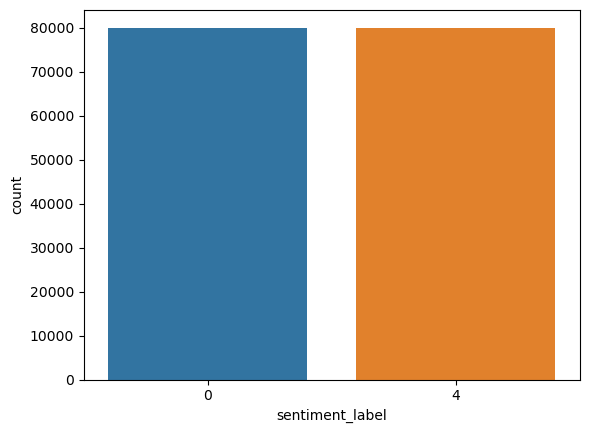

In [6]:
sns.countplot(x='sentiment_label', data=df)

In [7]:
decode_map = {0: "NEGATIVE", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df['target_str'] = df.sentiment_label.apply(lambda x: decode_sentiment(x))

CPU times: user 32.7 ms, sys: 1.57 ms, total: 34.3 ms
Wall time: 33.1 ms


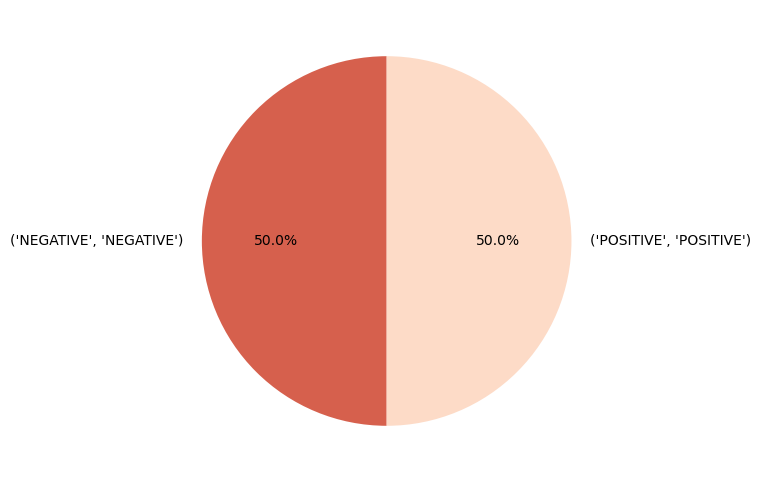

In [9]:
# Distribution of Target Variable
df_target_dist=df.groupby('target_str')

with sns.color_palette("RdBu",4):
    plt.figure(figsize=(14,6))
    labels = df_target_dist['target_str'].value_counts().index
    plt.pie(df_target_dist['target_str'].value_counts(), labels= labels, startangle=90, autopct='%.1f%%')
    plt.show()

/var/folders/13/ts743l9s68547pd3v1mkd3d80000gn/T/ipykernel_2115/1925061017.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a=sns.histplot([len(s) for s in df.tweet_text], bins=50, palette='Set1')


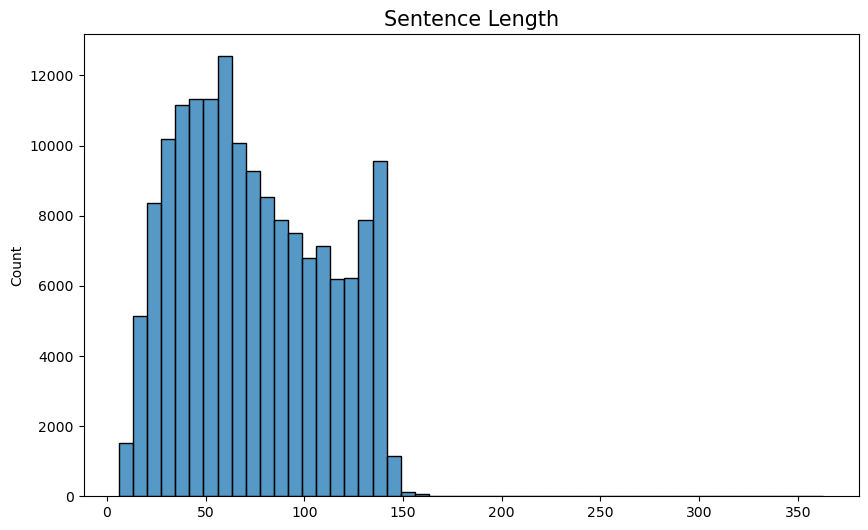

In [10]:
# Length of Tweets
#plot hist of sentence length
plt.figure(figsize=(10, 6))
a=sns.histplot([len(s) for s in df.tweet_text], bins=50, palette='Set1')
a.set_title("Sentence Length",fontsize=15)
plt.show()

/var/folders/13/ts743l9s68547pd3v1mkd3d80000gn/T/ipykernel_2115/2146942849.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  a=sns.histplot((df['tweet_text'].str.split().map(lambda x: len(x))), bins=50, palette='Set1')


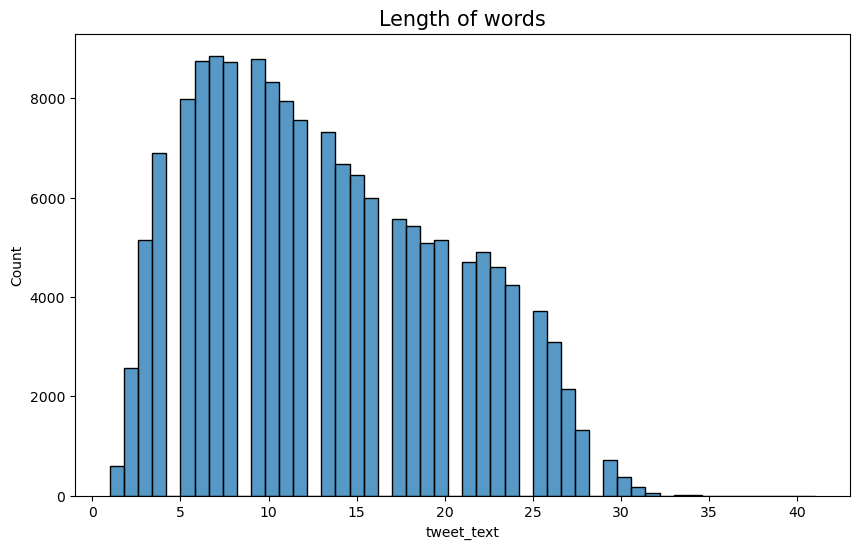

In [11]:
# Length of Words
#plot hist of sentence length
plt.figure(figsize=(10, 6))
a=sns.histplot((df['tweet_text'].str.split().map(lambda x: len(x))), bins=50, palette='Set1')
a.set_title("Length of words",fontsize=15)
plt.show()

In [12]:
df.columns

Index(['sentiment_label', 'tweet_text', 'target_str'], dtype='object')

In [13]:
# Data Cleaning and Feature Engineering
#replacing
df.sentiment_label=np.where(df.sentiment_label == 4, 1, 0) 

I got this code online for cleaning sentiment analysis data

Now, the first step is to remove the noisy data like punctuations, hashtags, @ and others that are not alphanumeric. Only alphanumeric data are meaningful data that can help us in identifying the sentiments. To remove the noisy data, we will import RegexpTokenizer which will split the strings into substrings based on a regular expression. The regular expression we will use is ‘\w+ which will tokenize all the alphanumeric data and remove all other noises from the tweets. You can go through this link to know about various tokenizers

In [14]:
# Data Cleaning 
def tweet_clean(tweet):
    tweet = re.sub(r'@[A-Za-z0-9]+'," ",tweet)            #Removing the usernames
    tweet = re.sub(r'^[A-Za-z0-9.!?]+'," ",tweet)         #Removing digits and punctuations
    tweet = re.sub(r'https?://[A-Za-z0-9./]+'," ",tweet)  #Removing link
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)            #convert "#topic" to just "topic"
    #tweet = re.sub(r"\'s", " ", tweet)
    tweet = re.sub(r"\'ve", " have ", tweet)
    #tweet = re.sub(r"n't", " not ", tweet)
    tweet = re.sub(r"\'d", " would ", tweet)
    tweet = re.sub(r"\'ll", " will ", tweet)
    tweet = tweet.lower()
    tweet = tweet.strip('. .')
    tweet = tweet.replace('.',' ')
    tweet = tweet.replace('?',' ')
    tweet = tweet.replace(',',' ')
    tweet = tweet.replace('-',' ')
    tweet = re.sub('[\s]+', ' ', tweet)                   #Correct all multiple white spaces to a single white space
    tweet = tweet.replace("’", "'").replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")
    tweet = tweet.replace("won't", "will not").replace("can't", "can not")
    tweet = tweet.replace("will not", "willnot").replace("can not", "cannot")
    tweet = tweet.replace("€", " euro ")
    tweet = tweet.replace("don't", "dont").replace("do not", "dont").replace("didn't", "didnot").replace("it's", "it is").replace("did not", "didnot")
    tweet = tweet.replace(",000,000", "m").replace("n't", " not").replace("what's", "what is")
    tweet = tweet.replace(",000", "k").replace("i'm", "i am").replace("'re", " are")
    tweet = tweet.replace("he's", "he is").replace("she's", "she is").replace("'s", " own")
    
    return tweet

df.tweet_text = df.tweet_text.apply(lambda x: tweet_clean(x))

In [15]:
df.head(10)

,sentiment_label,tweet_text,target_str
0,1,hey dear happy friday to you already had your ...,POSITIVE
1,1,layin downnnn waiting for zeina to cook breakfast,POSITIVE
2,0,i reckon he will play even if he is not 100 pe...,NEGATIVE
3,0,i know! saw it on the news!,NEGATIVE
4,0,sad that has closed down one of the few web se...,NEGATIVE
5,0,who sings 'i remember' i alwaysss hear it on r...,NEGATIVE
6,1,god on ur side anything is possible,POSITIVE
7,0,why being stupid,NEGATIVE
8,0,delved back into the guts of expression engine...,NEGATIVE
9,0,awww take him with you!,NEGATIVE


In [16]:
# Stopwords and Stemming
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))
stemmer=SnowballStemmer('english')

def preprocess(text, stem=False):
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

df.tweet_text = df.tweet_text.apply(lambda x: preprocess(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/laminjatta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
# Removing Small Words
def smallwords(text):
    tokens = []
    for token in text.split():
        if len(token)>2:
            tokens.append(token)
    return " ".join(tokens)

df.tweet_text = df.tweet_text.apply(lambda x: smallwords(x))

In [18]:
df.head()

,sentiment_label,tweet_text,target_str
0,1,hey dear happy friday already rice bowl lunch,POSITIVE
1,1,layin downnnn waiting zeina cook breakfast,POSITIVE
2,0,reckon play even 100 percent know nothing!! wi...,NEGATIVE
3,0,know! saw news!,NEGATIVE
4,0,sad closed one web services used years,NEGATIVE


In [19]:
# Most Frequent Words in Positive and Negative Tweets
# Spliting dataset to negatives and positives for EDA
negatives=df['sentiment_label']==0
positives=df['sentiment_label']==1

# Number of words for each tweet
df['No_of_Words']=[len(text.split()) for text in df['tweet_text']]

In [20]:
df['Words'] = df['tweet_text'].apply(lambda x:str(x).split())

top_pos = Counter([word for text in df[positives]['Words'] for word in text])
top_pos_df=pd.DataFrame(top_pos.most_common(100),columns=['Words','Counts'])

top_neg = Counter([word for text in df[negatives]['Words'] for word in text])
top_neg_df=pd.DataFrame(top_neg.most_common(100),columns=['Words','Counts'])

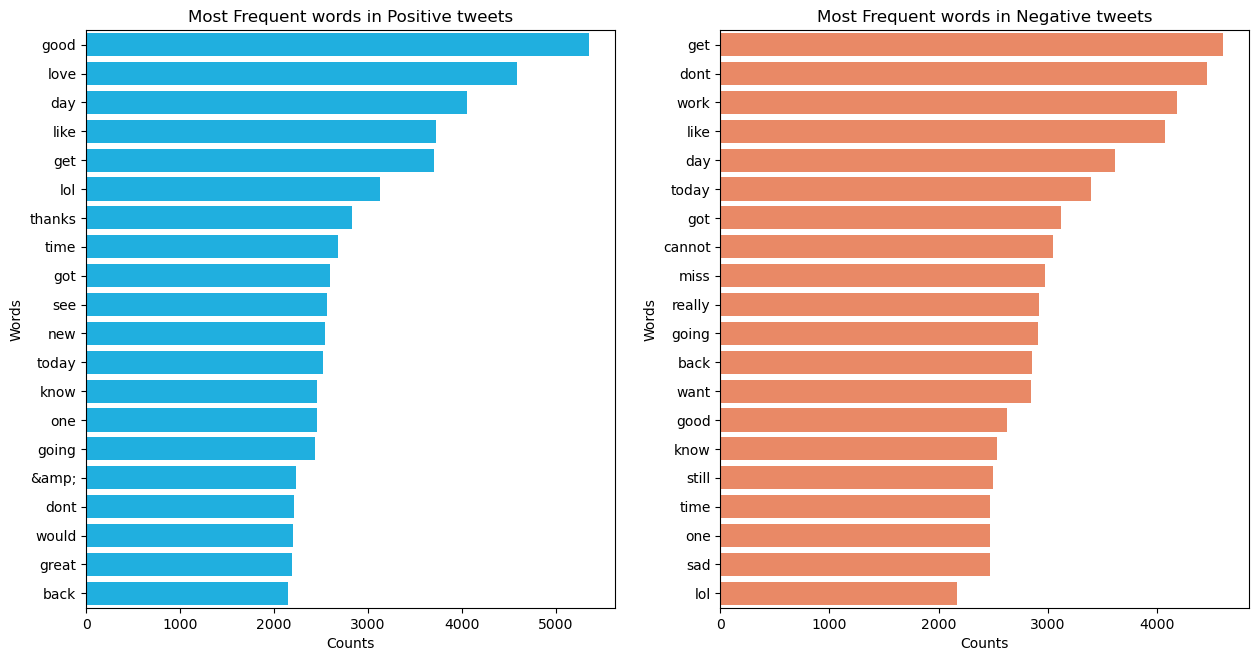

In [21]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(15,7.5))
sns.barplot(y='Words',x='Counts',data=top_pos_df[:20],color='deepskyblue',ax=ax[0])
sns.barplot(y='Words',x='Counts',data=top_neg_df[:20],color='coral',ax=ax[1])
ax[0].set_title("Most Frequent words in Positive tweets")
ax[1].set_title("Most Frequent words in Negative tweets")
plt.show()

In [22]:
# N-grams
df_pos=df[df['sentiment_label']==1]
df_neg=df[df['sentiment_label']==0]

## visualising top n-grams

def get_top_word_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_word_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

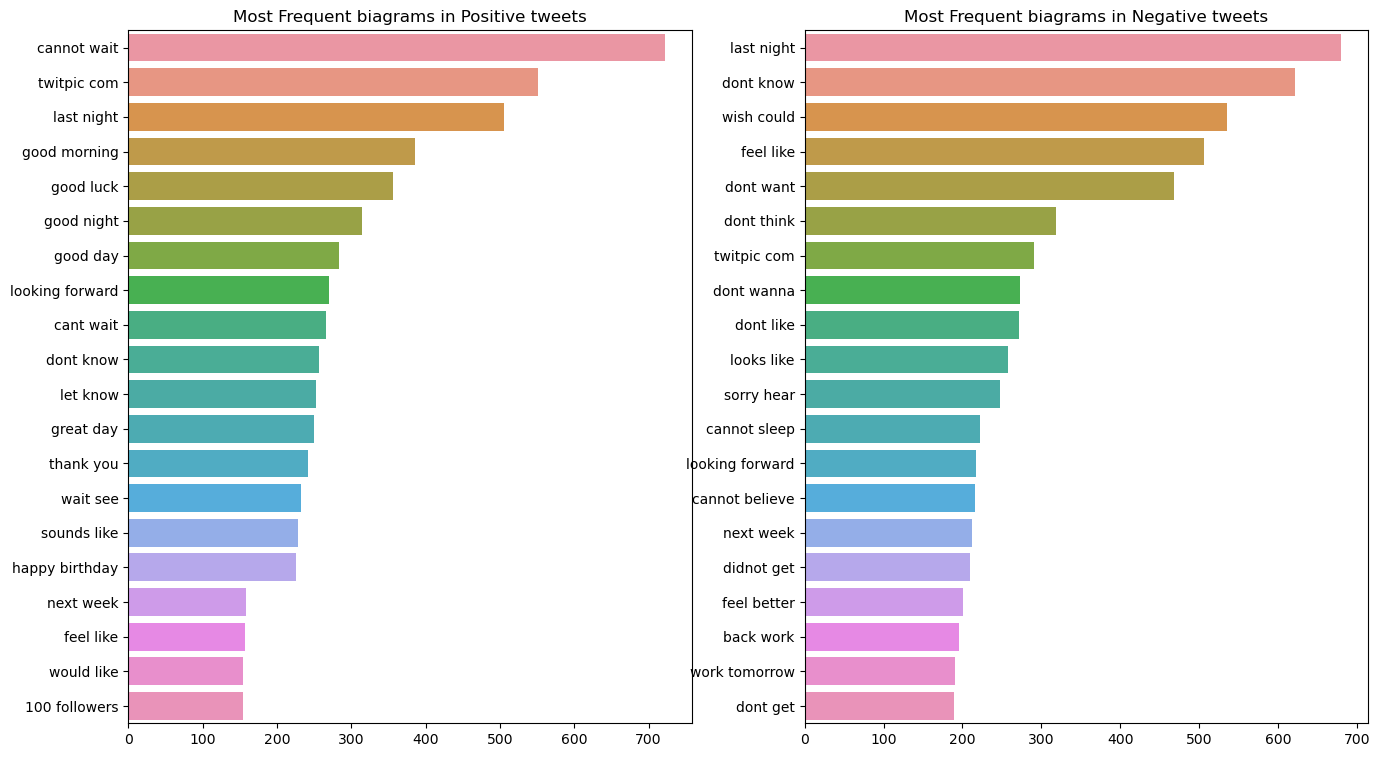

In [23]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(16,9))
top_tweet_bigrams_pos=get_top_word_bigrams(df_pos['tweet_text'])[:20]
x,y=map(list,zip(*top_tweet_bigrams_pos))
sns.barplot(x=y,y=x,ax=ax[0])
top_tweet_bigrams_neg=get_top_word_bigrams(df_neg['tweet_text'])[:20]
x,y=map(list,zip(*top_tweet_bigrams_neg))
sns.barplot(x=y,y=x,ax=ax[1])
ax[0].set_title("Most Frequent biagrams in Positive tweets")
ax[1].set_title("Most Frequent biagrams in Negative tweets")
plt.show()

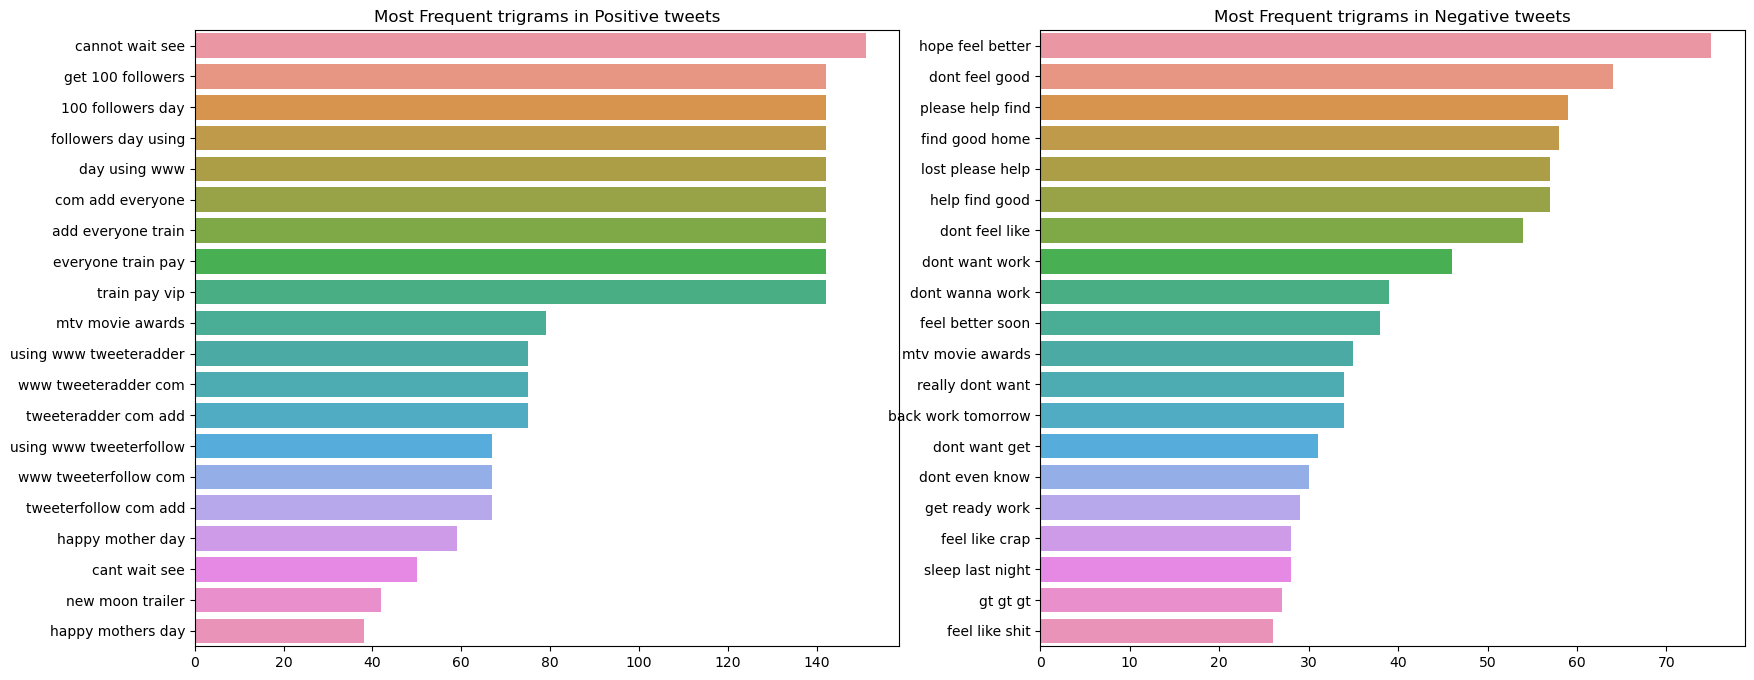

In [24]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,8))
top_tweet_trigrams_pos=get_top_word_trigrams(df_pos['tweet_text'])[:20]
x,y=map(list,zip(*top_tweet_trigrams_pos))
sns.barplot(x=y,y=x,ax=ax[0])
top_tweet_trigrams_neg=get_top_word_trigrams(df_neg['tweet_text'])[:20]
x,y=map(list,zip(*top_tweet_trigrams_neg))
sns.barplot(x=y,y=x,ax=ax[1])
ax[0].set_title("Most Frequent trigrams in Positive tweets")
ax[1].set_title("Most Frequent trigrams in Negative tweets")
plt.show()

### Feature Engineering for LSTM Model

In [25]:
# Train and Test Split

TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 80

In [26]:
x_train,x_test,y_train,y_test = train_test_split(df['tweet_text'],df['sentiment_label'] , test_size=.2,stratify=df['sentiment_label'], random_state=0)

In [27]:
# Word2Vec
documents = [text.split() for text in x_train]

In [28]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=80,
                                            window=7, 
                                            min_count=10, 
                                            workers=6)

In [29]:
w2v_model.build_vocab(documents)
words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 7434


In [30]:
w2v_model.train(documents, total_examples=len(documents), epochs=30)

(19648989, 25371900)

In [31]:
w2v_model.wv.most_similar("good")

[('great', 0.5251661539077759),
 ('bad', 0.4881158769130707),
 ('shitty', 0.48719921708106995),
 ('rough', 0.45599982142448425),
 ('gooood', 0.44967570900917053),
 ('lovely', 0.44796445965766907),
 ('good!', 0.44612523913383484),
 ('hungover', 0.4359697103500366),
 ('wonderful', 0.42534583806991577),
 ('like!', 0.42372700572013855)]

In [32]:
# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 64927


In [33]:
x_train = pad_sequences(tokenizer.texts_to_sequences(x_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(x_test),
                        maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (128000, 80)
Testing X Shape: (32000, 80)


In [34]:
x_train

array([[    0,     0,     0, ...,    90,   882,   894],
       [    0,     0,     0, ...,    17,  9385,    16],
       [    0,     0,     0, ...,    25,     3, 25454],
       ...,
       [    0,     0,     0, ...,   380,    10, 25238],
       [    0,     0,     0, ...,    23,  5061,   109],
       [    0,     0,     0, ...,   136,    30,  9340]], dtype=int32)

In [35]:
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (128000, 1)
y_test shape: (32000, 1)


In [36]:
print("Label balence of train is "+str(y_train.sum()/len(y_train))+". For test is "+str(y_test.sum()/len(y_test)))

Label balence of train is 0.5. For test is 0.5


In [37]:
# Embedding Matrix and Layer

In [38]:
embedding_matrix = np.zeros((vocab_size, 80))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(64927, 80)


In [39]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.50144005, -0.25604185, -1.52299821, ..., -1.46685565,
         0.01541494,  1.03356564],
       [-0.87149948,  0.15484497,  0.50006849, ..., -0.20670076,
        -0.64517742,  0.67180616],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [40]:
embedding_layer = Embedding(vocab_size, 80, weights=[embedding_matrix], input_length=80, trainable=False)

In [41]:
# Feature Engineering for Other Models
# Count Vectorizer
count_vectorizer = CountVectorizer(stop_words='english') 
cv = count_vectorizer.fit_transform(df['tweet_text'])
cv.shape

(160000, 74222)

In [42]:
# Train-Test Split
X_train,X_test,Y_train,Y_test = train_test_split(cv,df['sentiment_label'] , test_size=.2,stratify=df['sentiment_label'], random_state=0)

In [43]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    Y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(Y_test, Y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(Y_test, Y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## LSTM

In [44]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(LSTM(80, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-02-19 12:30:54.972681: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-19 12:30:54.973148: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 80)            5194160   
                                                                 
 dropout (Dropout)           (None, 80, 80)            0         
                                                                 
 lstm (LSTM)                 (None, 80)                51520     
                                                                 
 dense (Dense)               (None, 1)                 81        
                                                                 
Total params: 5,245,761
Trainable params: 51,601
Non-trainable params: 5,194,160
_________________________________________________________________


In [45]:
model.compile(loss='binary_crossentropy',
                optimizer="adam",
                metrics=['accuracy'])

In [46]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [47]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.11.0


In [48]:
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
#with tf.device('/GPU:0'):
model_history=model.fit(x_train, y_train, batch_size=128, epochs=20, validation_split=0.1, verbose=1)

In [50]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 80, weights=[embedding_matrix], input_length=80 , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 80, 80)            5194160   
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6401      
                                                                 
Total params: 5,200,561
Trainable params: 6,401
Non-trainable params: 5,194,160
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

#history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.1)

In [ ]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs=range(len(acc))

In [ ]:
plt.plot(epochs,acc,label='Trainin_acc',color='blue')
plt.plot(epochs,val_acc,label='Validation_acc',color='red')
plt.legend()
plt.title("Training and Validation Accuracy")

In [ ]:
plt.plot(epochs,loss,label='Training_loss',color='blue')
plt.plot(epochs,val_loss,label='Validation_loss',color='red')
plt.legend()
plt.title("Training and Validation loss")

In [54]:
# Prediction

predictions = model.predict(x_test, verbose=1, batch_size=1024)
y_pred=np.where(predictions>0.5,1,0)

print(classification_report(y_test, y_pred))

2023-02-19 12:37:52.068032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.51      0.51      0.51     16000
           1       0.51      0.51      0.51     16000

    accuracy                           0.51     32000
   macro avg       0.51      0.51      0.51     32000
weighted avg       0.51      0.51      0.51     32000



In [71]:
df

,sentiment_label,tweet_text,target_str,No_of_Words,Words
0,1,hey dear happy friday already rice bowl lunch,POSITIVE,8,"[hey, dear, happy, friday, already, rice, bowl..."
1,1,layin downnnn waiting zeina cook breakfast,POSITIVE,6,"[layin, downnnn, waiting, zeina, cook, breakfast]"
2,0,reckon play even 100 percent know nothing!! wi...,NEGATIVE,9,"[reckon, play, even, 100, percent, know, nothi..."
3,0,know! saw news!,NEGATIVE,3,"[know!, saw, news!]"
4,0,sad closed one web services used years,NEGATIVE,7,"[sad, closed, one, web, services, used, years]"
...,...,...,...,...,...
159995,0,panera studying &quot;mock&quot; board exams t...,NEGATIVE,7,"[panera, studying, &quot;mock&quot;, board, ex..."
159996,0,control tonight slept wink,NEGATIVE,4,"[control, tonight, slept, wink]"
159997,1,take pride,POSITIVE,2,"[take, pride]"
159998,1,work,POSITIVE,1,[work]


## Logistic Regression

In [72]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Preprocess data
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['tweet_text'])
y = df['sentiment_label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Train logistic regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Evaluate model on testing set
y_pred = lr.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)


Accuracy: 0.7563541666666667


              precision    recall  f1-score   support

           0       0.76      0.71      0.73     16000
           1       0.73      0.77      0.75     16000

    accuracy                           0.74     32000
   macro avg       0.74      0.74      0.74     32000
weighted avg       0.74      0.74      0.74     32000

CPU times: user 1.82 s, sys: 340 ms, total: 2.16 s
Wall time: 1.91 s


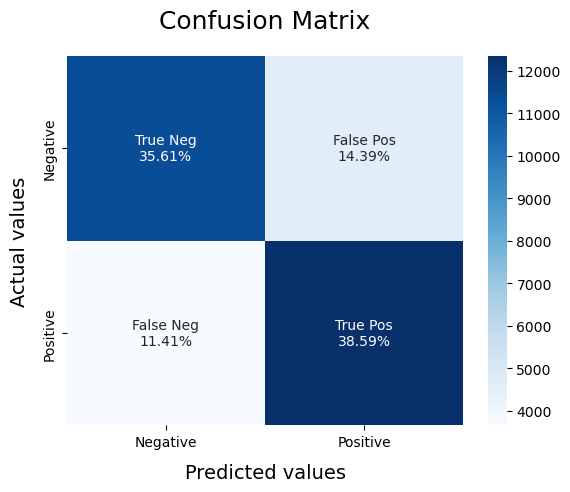

In [70]:
%%time
import warnings
from sklearn.exceptions import ConvergenceWarning

# Filter out ConvergenceWarnings
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)


lr = LogisticRegression()
lr.fit(X_train,Y_train)
prediction_lr = lr.predict(X_test)
model_Evaluate(lr)

              precision    recall  f1-score   support

           0       0.76      0.71      0.73     16000
           1       0.73      0.77      0.75     16000

    accuracy                           0.74     32000
   macro avg       0.74      0.74      0.74     32000
weighted avg       0.74      0.74      0.74     32000



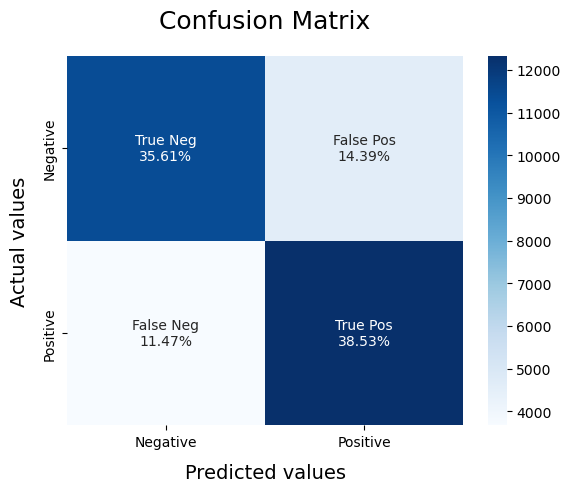

In [66]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Filter out ConvergenceWarnings
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Train the model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, Y_train)

prediction_lr = lr.predict(X_test)

# Evaluate the model and print the classification report
model_Evaluate(lr)

# Create a confusion matrix
cm = confusion_matrix(Y_test, prediction_lr)

# Plot the confusion matrix as a heatmap
#sns.heatmap(cm, annot=True, cmap="Blues")
plt.show()

## XGBoost

              precision    recall  f1-score   support

           0       0.77      0.69      0.73     16000
           1       0.72      0.79      0.76     16000

    accuracy                           0.74     32000
   macro avg       0.75      0.74      0.74     32000
weighted avg       0.75      0.74      0.74     32000

CPU times: user 4min 19s, sys: 5 s, total: 4min 24s
Wall time: 1min 4s


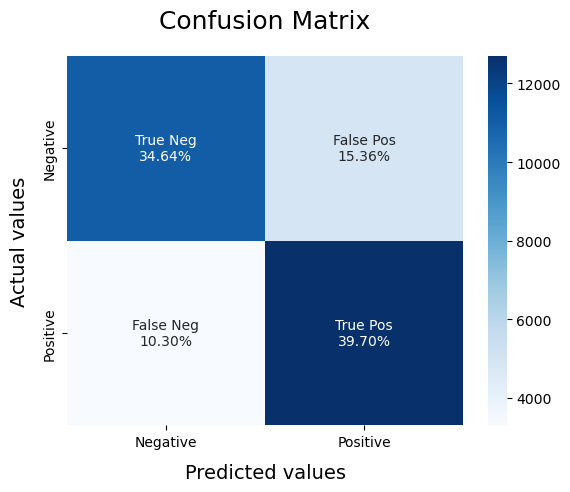

In [56]:
%%time
xgbc = XGBClassifier(max_depth=10, n_estimators=1000, nthread= 6)
xgbc.fit(X_train,Y_train)
prediction_xgb = xgbc.predict(X_test)
model_Evaluate(xgbc)

## Convoulution Neural Network

In [57]:
# maxlen = 80
cnn_model = Sequential()

embedding_layer = Embedding(vocab_size, 80, weights=[embedding_matrix], input_length=80, trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [58]:
print(cnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 80, 80)            5194160   
                                                                 
 conv1d (Conv1D)             (None, 76, 128)           51328     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 5,245,617
Trainable params: 51,457
Non-trainable params: 5,194,160
_________________________________________________________________
None


In [59]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [60]:
history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = cnn_model.evaluate(X_test, y_test, verbose=1)

ValueError: `validation_split` is only supported for Tensors or NumPy arrays, found following types in the input: [<class 'scipy.sparse._csr.csr_matrix'>]

In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Recurrent Neural Network RNN

In [61]:
rnn_model = Sequential()
embedding_layer = Embedding(vocab_size, 80, weights=[embedding_matrix], input_length=80, trainable=False)
rnn_model.add(embedding_layer)
rnn_model.add(LSTM(128))

rnn_model.add(Dense(1, activation='sigmoid'))
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [62]:
print(rnn_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 80, 80)            5194160   
                                                                 
 lstm_1 (LSTM)               (None, 128)               107008    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 5,301,297
Trainable params: 107,137
Non-trainable params: 5,194,160
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])


In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
instance = X[57]
print(instance)

In [ ]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=80)

model.predict(instance)